# Assumption 2 Random Companies in 2019

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import jit, njit, vectorize
from glob import glob
import re
import seaborn as sns
import pickle
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

from fastai.tabular.transform import add_datepart
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import concurrent.futures

pd.set_option('display.max_columns', None) 

%matplotlib inline

In [2]:
dtypes={'JobID': np.str, 'CleanJobTitle': np.str, 'JobDomain': np.str, 
        'CanonCity': np.str, 'CanonCountry': np.str, 'CanonState': np.str, 
        'JobText': np.str, 'JobURL': np.str, 'PostingHTML': np.float64, 
        'Source': np.str, 'JobReferenceID': np.str, 'Email': np.str, 
        'CanonEmployer': np.str, 'Latitude': np.str, 'Longitude': np.str, 
        'CanonIntermediary': np.str, 'Telephone': np.str, 'CanonJobTitle': 'object', 
        'CanonCounty': np.str, 'DivisionCode': np.float64, 'MSA': np.str, 'LMA': np.str,
        'InternshipFlag': np.str, 'ConsolidatedONET': np.str, 'CanonCertification': np.str, 
        'CanonSkillClusters': np.str, 'CanonSkills': np.str, 'IsDuplicate': np.str, 
        'IsDuplicateOf': np.float64, 'CanonMaximumDegree': np.str, 'CanonMinimumDegree': np.str, 
        'CanonOtherDegrees': np.str, 'CanonPreferredDegrees': np.str,
        'CanonRequiredDegrees': np.str, 'CIPCode': np.str, 'StandardMajor': np.str, 
        'MaxExperience': np.float64, 'MinExperience': np.float64, 'ConsolidatedInferredNAICS': np.float64, 
        'BGTOcc': np.str, 'MaxAnnualSalary': np.float64, 'MaxHourlySalary': np.float64, 
        'MinAnnualSalary': np.float64, 'MinHourlySalary': np.float64, 'YearsOfExperience': np.str, 
        'CanonJobHours': np.str, 'CanonJobType': np.str, 'CanonPostalCode': np.str, 
        'CanonYearsOfExperienceCanonLevel': np.str, 'CanonYearsOfExperienceLevel': np.str, 
        'ConsolidatedTitle': np.str, 'Language': np.str, 'BGTSubOcc': np.str, 'JobDate': np.str,
        'ConsolidatedDegreeLevels': np.str, 'MaxDegreeLevel': np.float64, 'MinDegreeLevel': np.float64
                       }

In [3]:
best_list = ['JobID', 'CleanJobTitle', 'CanonCity', 'CanonState', 'JobDate', 'JobText', 'Source', 'CanonEmployer',
             'Latitude', 'Longitude', 'CanonIntermediary', 'CanonJobTitle', 'CanonCounty', 'DivisionCode', 'MSA', 'LMA',
             'InternshipFlag', 'ConsolidatedONET', 'CanonSkillClusters', 'CanonSkills', 'IsDuplicate', 'CanonMinimumDegree', 
             'CanonRequiredDegrees', 'CIPCode', 'MinExperience', 'ConsolidatedInferredNAICS', 'BGTOcc', 'MaxAnnualSalary',
             'MaxHourlySalary', 'MinAnnualSalary', 'MinHourlySalary', 'YearsOfExperience', 'CanonJobHours', 'CanonJobType',
             'CanonPostalCode', 'CanonYearsOfExperienceCanonLevel', 'CanonYearsOfExperienceLevel', 'ConsolidatedTitle', 
             'Language', 'BGTSubOcc', 'ConsolidatedDegreeLevels', 'MaxDegreeLevel', 'MinDegreeLevel']

In [5]:
path = '/Volumes/LaCie SSD/bgdata/data_19/data_19_0101_0107.csv'

In [6]:
%%time

df = pd.read_csv(path, low_memory=False, parse_dates=['JobDate'], usecols=best_list, dtype=dtypes)

CPU times: user 12.3 s, sys: 6.2 s, total: 18.5 s
Wall time: 23.7 s


In [7]:
df = df[df['JobText'].notna()].copy()

In [9]:
missing_vals = df.isnull().sum() / df.shape[0] * 100
missing_vals

JobID                                0.000000
CleanJobTitle                        0.012026
CanonCity                            0.836084
CanonState                           0.038783
JobDate                              0.000000
JobText                              0.000000
Source                               8.151896
CanonEmployer                       20.358846
Latitude                             0.798203
Longitude                            0.798203
CanonIntermediary                   89.337145
CanonJobTitle                       38.040478
CanonCounty                          0.838489
DivisionCode                        64.997505
MSA                                  2.486907
LMA                                  1.051043
InternshipFlag                       0.000000
ConsolidatedONET                     3.908942
CanonSkillClusters                   4.746228
CanonSkills                          0.000000
IsDuplicate                          0.000000
CanonMinimumDegree                

In [10]:
to_drop = (missing_vals[missing_vals > 70]).index

In [11]:
df.drop(to_drop, axis=1, inplace=True)
df.head(3)

,JobID,CleanJobTitle,CanonCity,CanonState,JobDate,JobText,Source,CanonEmployer,Latitude,Longitude,CanonJobTitle,CanonCounty,DivisionCode,MSA,LMA,InternshipFlag,ConsolidatedONET,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,MinExperience,ConsolidatedInferredNAICS,BGTOcc,YearsOfExperience,CanonJobHours,CanonJobType,CanonPostalCode,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedTitle,Language,BGTSubOcc,ConsolidatedDegreeLevels,MinDegreeLevel
0,38472243834,Sdet,San Francisco,CA,2019-01-01,SDET\n\nABOTTS Consulting\n\n-\n\nSan Francisc...,Job Board,NaN,37.7798,-122.417,NaN,San Francisco,41884.0,41860: Metropolitan Statistical Area|488: Comb...,DV064188|MT064186,0,17205100,Specialized Skills|Information Technology: Sof...,"{'Analytical Skills': 'Specialized Skills', 'A...",FALSE,Bachelor's in Computer Science,Bachelor's|Bachelor's in Computer Science,5.0,NaN,17-2051.00,5+ years|6 years,fulltime,temporary,94101,1-6,mid,Sdet,en,Civil Engineer,16,16.0
1,38472243883,Skilled Nursing Biller,Kannapolis,NC,2019-01-01,Skilled Nursing Biller\n\nGatewood Healthcare ...,Job Board,NaN,35.4971,-80.65,NaN,Cabarrus,NaN,16740: Metropolitan Statistical Area,MT371674,0,29114100,Finance: Billing and Invoicing;Specialized Ski...,{'Billing': 'Finance: Billing and Invoicing;Sp...,FALSE,NaN,NaN,2.0,6231.0,29-1141.00,Minimum of two years,fulltime,permanent,28081,1-6,mid,Nursing Biller,en,Registered Nurse,NaN,NaN
2,38472243901,Senior Engineer,Cincinnati,OH,2019-01-01,View All num of num Close (Esc)\n\nGreater Cin...,Job Board,Greater Cincinnati Water Works,39.1072,-84.5004,NaN,Hamilton,NaN,17140: Metropolitan Statistical Area,MT391714,0,17205100,Specialized Skills|Architecture and Constructi...,"{'Calculation': 'Specialized Skills', 'Cost Es...",FALSE,Bachelor's,Bachelor's,NaN,NaN,17-2051.00,one year,fulltime,permanent,45201,NaN,NaN,Senior Engineer,en,Civil Engineer,16,16.0


In [12]:
companies = df.groupby(['CanonEmployer'])

In [13]:
companies[['BGTOcc','ConsolidatedInferredNAICS', 'ConsolidatedONET']].agg(['count'])

,BGTOcc,ConsolidatedInferredNAICS,ConsolidatedONET
,count,count,count
CanonEmployer,,,
'datto',2,0,2
1 0 Granny's Helpful Hands,1,0,1
1 800 Accountant,0,0,0
1 800 Got Junk Brooklyn Queens,1,0,1
1 800 Got Junk New,1,0,1
...,...,...,...
eBay,18,18,18
exp,1,2,1


In [14]:
df['BGTOcc'].str.replace('-', '').astype(np.float32).isna().sum()

23156

In [15]:
df = df[df['BGTOcc'].notna()].copy()

In [16]:
df['BGTOcc'] = df['BGTOcc'].str.replace('-', '').astype(np.float32).astype(np.int32)
df['BGTOcc'].head()

0    172051
1    291141
2    172051
3    434051
4    399021
Name: BGTOcc, dtype: int32

In [17]:
occupations_df = pd.read_csv('/Users/ramonperez/Dropbox/Burning Glass/Analysis/occupations_clean.csv')
occupations_df.head()

,Occupation\ncode,Occupation text
0,110000,Management Occupations
1,112022,Sales Managers
2,113021,Computer and Information Systems Managers
3,113131,Training and Development Managers
4,119021,Construction Managers


In [18]:
occupations_df.columns = ['occu_code', 'occu_text']
occupations_df.columns

Index(['occu_code', 'occu_text'], dtype='object')

In [19]:
occupations_df.shape

(564, 2)

In [21]:
df.shape

(309466, 36)

In [20]:
occupations_df = occupations_df.astype({'occu_code': np.int32})

In [22]:
new_df = df.merge(occupations_df, left_on='BGTOcc', right_on='occu_code', how='inner')
new_df.head()

,JobID,CleanJobTitle,CanonCity,CanonState,JobDate,JobText,Source,CanonEmployer,Latitude,Longitude,CanonJobTitle,CanonCounty,DivisionCode,MSA,LMA,InternshipFlag,ConsolidatedONET,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,MinExperience,ConsolidatedInferredNAICS,BGTOcc,YearsOfExperience,CanonJobHours,CanonJobType,CanonPostalCode,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedTitle,Language,BGTSubOcc,ConsolidatedDegreeLevels,MinDegreeLevel,occu_code,occu_text
0,38472243834,Sdet,San Francisco,CA,2019-01-01,SDET\n\nABOTTS Consulting\n\n-\n\nSan Francisc...,Job Board,NaN,37.7798,-122.417,NaN,San Francisco,41884.0,41860: Metropolitan Statistical Area|488: Comb...,DV064188|MT064186,0,17205100,Specialized Skills|Information Technology: Sof...,"{'Analytical Skills': 'Specialized Skills', 'A...",FALSE,Bachelor's in Computer Science,Bachelor's|Bachelor's in Computer Science,5.0,NaN,172051,5+ years|6 years,fulltime,temporary,94101,1-6,mid,Sdet,en,Civil Engineer,16,16.0,172051,Civil Engineers
1,38472243901,Senior Engineer,Cincinnati,OH,2019-01-01,View All num of num Close (Esc)\n\nGreater Cin...,Job Board,Greater Cincinnati Water Works,39.1072,-84.5004,NaN,Hamilton,NaN,17140: Metropolitan Statistical Area,MT391714,0,17205100,Specialized Skills|Architecture and Constructi...,"{'Calculation': 'Specialized Skills', 'Cost Es...",FALSE,Bachelor's,Bachelor's,NaN,NaN,172051,one year,fulltime,permanent,45201,NaN,NaN,Senior Engineer,en,Civil Engineer,16,16.0,172051,Civil Engineers
2,38472244021,Structural Engineer,Cincinnati,OH,2019-01-01,View All num of num Close (Esc)\n\nBergaila Lo...,Job Board,Bergaila,39.1072,-84.5004,Structural Engineer,Hamilton,NaN,17140: Metropolitan Statistical Area,MT391714,0,17205100,Specialized Skills|Industry Knowledge: Civil E...,"{'Calculation': 'Specialized Skills', 'Heavy I...",FALSE,Bachelor's,Bachelor's,2.0,NaN,172051,2+ years,NaN,NaN,45201,1-6,mid,Structural Engineer,en,Civil Engineer,16,16.0,172051,Civil Engineers
3,38472245356,Roadway Engineer,Pittsburgh,PA,2019-01-01,View All num of num Close (Esc)\n\nA. Morton T...,Job Board,A Morton Thomas Associates,40.3774,-79.8926,Roadway Engineer,Allegheny,NaN,38300: Metropolitan Statistical Area,MT423830,0,17205100,Information Technology: Geographic Information...,{'ArcGIS': 'Information Technology: Geographic...,FALSE,Bachelor of Science,Bachelor of Science,10.0,NaN,172051,minimum of 5 years|minimum 10+ years|5) years,NaN,NaN,15122,6+,high,Roadway Engineer,en,Civil Engineer,16,16.0,172051,Civil Engineers
4,38472247855,Traffic Engineer,Pittsburgh,PA,2019-01-01,View All num of num Close (Esc)\n\nA. Morton T...,Job Board,A Morton Thomas Associates,40.3774,-79.8926,Traffic Engineer,Allegheny,NaN,38300: Metropolitan Statistical Area,MT423830,0,17205100,Specialized Skills|Engineering: Drafting and E...,{'Asset Management Industry Knowledge': 'Speci...,FALSE,Bachelor of Science,Bachelor of Science|Master of Science,5.0,NaN,172051,5) years,NaN,NaN,15122,1-6,mid,Traffic Engineer,en,Civil Engineer,16|18,16.0,172051,Civil Engineers


In [23]:
new_df.shape

(277417, 38)

In [24]:
companies = new_df.groupby(['CanonEmployer'])
companies['occu_text'].agg(['count'])

,count
CanonEmployer,
'datto',1
1 0 Granny's Helpful Hands,1
1 800 Got Junk Brooklyn Queens,1
1 800 Got Junk New,1
1 800 Hansons,1
...,...
comScore,2
eBay,15
iRobot,3


In [31]:
new_df = new_df.sample(10000)

# a. For each firm, the number of occupations

In [32]:
comps = [x for x in list(new_df['CanonEmployer'].unique()) if str(x) != 'nan']
comps[:10]

['Wade Jurney Homes',
 'Dignity Health',
 'The Home Depot Incorporated',
 "Jimmy John's",
 'Geico',
 'KFC',
 'Keurig Dr Pepper',
 'Champion Fence',
 'Starbucks Coffee Company',
 'Well States Healthcare']

In [33]:
unique_occ_comp = {}
unique_occ_nums = {}

for comp in comps:
    unique_occs = list(new_df.loc[new_df['CanonEmployer'] == comp, 'occu_text'].unique())
    number_occs = len(new_df.loc[new_df['CanonEmployer'] == comp, 'occu_text'].unique())
    unique_occ_comp[comp] = unique_occs
    unique_occ_nums[comp] = number_occs

In [34]:
from pprint import pprint
pprint(unique_occ_nums)

{'1 800Courier': 1,
 '10286200': 1,
 '10X Genomics': 1,
 '110 Grill Restaurant': 1,
 '168 Investment & Management Services Llc': 1,
 '1St Choice Llc': 2,
 '1St Choice Nanny Service, Llc': 1,
 '2313': 1,
 '24 Hour Fitness': 5,
 '247 Ai': 1,
 '24Hr Homecare': 1,
 '3 Fold Marketing': 1,
 '3A Soft Inc': 1,
 '3M Company': 1,
 '3Q Digital': 1,
 '5280 Productions Llc': 1,
 '7-Eleven': 3,
 '84 Lumber Company': 1,
 '99 Cents Only': 1,
 '99 Cents Only Stores': 1,
 '9Round Com Fitness & Kickboxing': 1,
 'A Max Insurance Services': 1,
 'A Step Above': 1,
 'A Toast To You': 1,
 'A&S Kinard': 1,
 'A&S Total Cleaning': 1,
 'A2C Consulting': 1,
 'A5': 1,
 'AAA': 4,
 'ABM Industries': 1,
 'ADT Security Services': 2,
 'AECOM Technology Corporation': 5,
 'AHMC Healthcare': 3,
 'AMC Entertainment': 1,
 'ARC Document Solutions': 1,
 'AT&T': 4,
 'Aacres Human Services': 1,
 'Aarkay Technologies': 1,
 "Aaron's": 2,
 'Ab Global Logistics Consulting': 1,
 'Abacus Solutions Group': 1,
 'Abacus Solutions Llc': 1

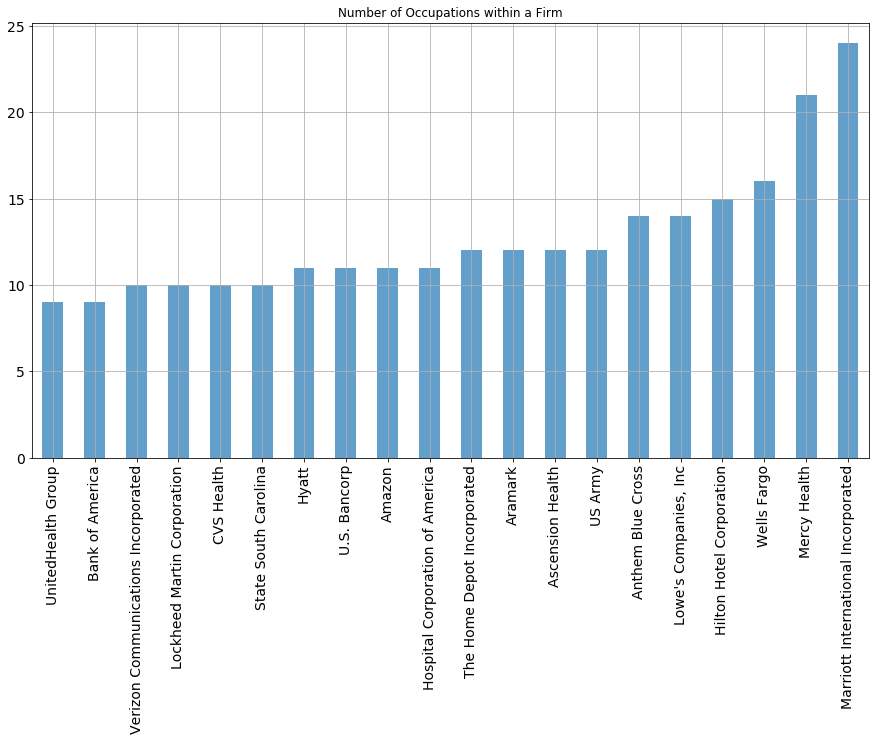

In [44]:
pd.Series(unique_occ_nums).sort_values()[-20:].plot(kind='bar',
                                              rot=90, 
                                              figsize=(15, 8),
                                              fontsize=14,
                                              title='Number of Occupations within a Firm',
                                              grid=True,
                                              alpha=0.70);

# b. For company-BGTOcc, unique number of job titles & list of those job titles

In [36]:
occups = [x for x in list(new_df['occu_text'].unique()) if str(x) != 'nan']
occups[:10]

['Construction Managers',
 'Registered Nurses',
 'Laborers and Freight, Stock, and Material Movers, Hand',
 'Food Service Managers',
 'Sales Representatives, Wholesale and Manufacturing, Technical and Scientific Products',
 'Web Developers',
 'Combined Food Preparation and Serving Workers, Including Fast Food',
 'Heavy and Tractor-Trailer Truck Drivers',
 'Computer Occupations, All Other',
 'Management Analysts']

In [37]:
jobs_name_unique = {}
jobs_nums_unique = {}

for comp in comps:
    unique_jobs = list(new_df.loc[new_df['CanonEmployer'] == comp, 'CanonJobTitle'].unique())
    number_jobs = len(new_df.loc[new_df['CanonEmployer'] == comp, 'CanonJobTitle'].unique())
    jobs_name_unique[comp] = unique_jobs
    jobs_nums_unique[comp] = number_jobs

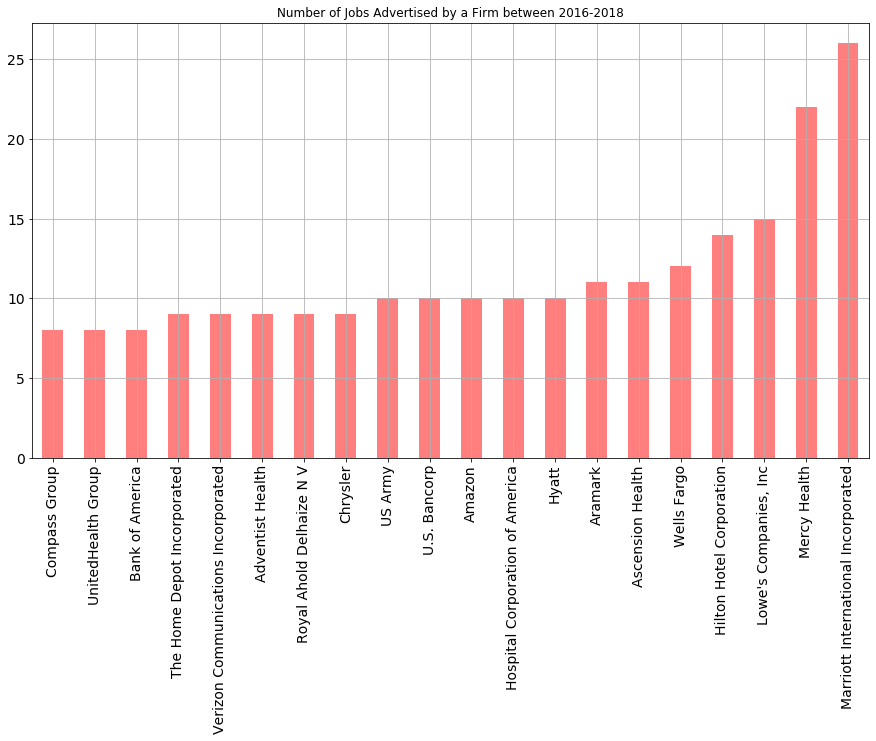

In [45]:
pd.Series(jobs_nums_unique).sort_values()[-20:].plot(kind='bar',
                                              rot=90, 
                                              figsize=(15, 8),
                                              fontsize=14,
                                              color='red',
                                              title='Number of Jobs Advertised by a Firm between 2016-2018',
                                              grid=True,
                                              alpha=0.50);

### Additional Step

In [ ]:
%%time

unique_jobs_names = {}
unique_jobs_nums = {}

for comp in comps:
    occ_text = {}
    occ_nums = {}
    for occu in occups:
        unique_jobs = list(new_df.loc[(new_df['CanonEmployer'] == comp) &
                                      (new_df['occu_text'] == occu), 'CanonJobTitle'].unique())
        number_jobs = len(new_df.loc[(new_df['CanonEmployer'] == comp) &
                                     (new_df['occu_text'] == occu), 'CanonJobTitle'].unique())
        occ_text[occu] = unique_jobs
        occ_nums[occu] = number_jobs
    unique_jobs_names[comp] = occ_text
    unique_jobs_nums[comp] = occ_nums

In [ ]:
pprint(unique_jobs_nums['Facebook'])

# c. For every job title, number of occupations it appears under

In [39]:
jobs = [x for x in list(new_df['CanonJobTitle'].unique()) if str(x) != 'nan']
jobs[:10]

['Clinical Nurse',
 'Web Developer',
 'Fast Food Team Member',
 'Class A CDL Truck Driver',
 'Sales Manager',
 'Hair Stylist',
 'Cashier',
 'Material Handler',
 'Advanced Practice Nurse',
 'Marketing Associate']

In [40]:
%%time

unique_jobs_occu_titles = {}
unique_jobs_occu_nums = {}

for job in jobs:
    unique_jobs = list(new_df.loc[new_df['CanonJobTitle'] == job, 'occu_text'].unique())
    number_jobs = len(new_df.loc[new_df['CanonJobTitle'] == job, 'occu_text'].unique())
    unique_jobs_occu_titles[job] = unique_jobs
    unique_jobs_occu_nums[job] = number_jobs

CPU times: user 2.22 s, sys: 12.6 ms, total: 2.23 s
Wall time: 2.26 s


In [41]:
pprint(unique_jobs_occu_nums)

{'.Net Developer': 1,
 '2Nd Presswoman': 1,
 '3D Generalist': 1,
 'A & P Mechanic': 1,
 'ASP .Net Developer': 1,
 'Academic Advisor': 1,
 'Academic Coordinator': 1,
 'Academic Counselor': 1,
 'Account Director': 3,
 'Account Executive': 1,
 'Account Manager': 3,
 'Account Representative': 2,
 'Accountant': 1,
 'Accounting Analyst': 1,
 'Accounting Assistant': 1,
 'Accounting Clerk': 1,
 'Accounting Coordinator': 1,
 'Accounting Specialist': 3,
 'Accounting Technician': 1,
 'Accounts Payable Clerk': 1,
 'Accounts Payable Manager': 1,
 'Accounts Payable Specialist': 1,
 'Accounts Payable Supervisor': 1,
 'Accounts Receivable Associate': 1,
 'Accounts Receivable Clerk': 1,
 'Accounts Receivable Coordinator': 1,
 'Accounts Receivable Manager': 1,
 'Accounts Receivable Representative': 1,
 'Accounts Receivable Specialist': 1,
 'Acquisition Analyst': 1,
 'Activities Assistant': 2,
 'Activities Coordinator': 1,
 'Adjunct Instructor': 1,
 'Administrative Analyst': 1,
 'Administrative Assistant